##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic text classification

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates text classification starting from plain text files stored on disk. You'll train a binary classifier to perform sentiment analysis on an IMDB dataset. At the end of the notebook, there is an exercise for you to try, in which you'll train a multi-class classifier to predict the tag for a programming question on Stack Overflow.


In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [4]:
print(tf.__version__)

2.13.0


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.


### Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

    8192/84125825 [..............................] - ETA: 0s

   73728/84125825 [..............................] - ETA: 1:02

  172032/84125825 [..............................] - ETA: 53s 

  335872/84125825 [..............................] - ETA: 41s

  630784/84125825 [..............................] - ETA: 29s

 1105920/84125825 [..............................] - ETA: 20s

 1810432/84125825 [..............................] - ETA: 15s

 2908160/84125825 [>.............................] - ETA: 10s

 4579328/84125825 [>.............................] - ETA: 7s 

 7266304/84125825 [=>............................] - ETA: 5s

11165696/84125825 [==>...........................] - ETA: 3s

16072704/84125825 [====>.........................] - ETA: 2s

21733376/84125825 [======>.......................] - ETA: 1s

27467776/84125825 [========>.....................] - ETA: 1s

33153024/84125825 [==========>...................] - ETA: 1s

38903808/84125825 [============>.................] - ETA: 0s

44589056/84125825 [==============>...............] - ETA: 0s

50323456/84125825 [================>.............] - ETA: 0s

56025088/84125825 [==================>...........] - ETA: 0s

61792256/84125825 [=====================>........] - ETA: 0s

67461120/84125825 [=======================>......] - ETA: 0s

73195520/84125825 [=========================>....] - ETA: 0s

78897152/84125825 [===========================>..] - ETA: 0s

84125825/84125825 [==============================] - 1s 0us/step


In [6]:
os.listdir(dataset_dir)

['imdb.vocab', 'train', 'test', 'README', 'imdbEr.txt']

In [7]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_neg.txt',
 'urls_pos.txt',
 'pos',
 'unsupBow.feat',
 'urls_unsup.txt',
 'neg',
 'labeledBow.feat',
 'unsup']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [8]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [9]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data. 

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set). 

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.


Using 20000 files for training.


As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section. 

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [12]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [13]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.


Using 5000 files for validation.


In [14]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer. 

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: To prevent [training-testing skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [15]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling adapt (using the test set would leak information).

In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [20]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [21]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training. 

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create your neural network:

In [23]:
embedding_dim = 16

In [24]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 embedding (Embedding)       (None, None, 16)          160016    


 dropout (Dropout)           (None, None, 16)          0         


 global_average_pooling1d (  (None, 16)                0         


 GlobalAveragePooling1D)                                         


 dropout_1 (Dropout)         (None, 16)                0         


 dense (Dense)               (None, 1)                 17        


Total params: 160033 (625.13 KB)


Trainable params: 160033 (625.13 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, check out the [Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings) tutorial.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [25]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [26]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


  1/625 [..............................] - ETA: 15:58 - loss: 0.6915 - binary_accuracy: 0.5625

  2/625 [..............................] - ETA: 1:55 - loss: 0.6937 - binary_accuracy: 0.4688 

  3/625 [..............................] - ETA: 1:55 - loss: 0.6928 - binary_accuracy: 0.5312

  4/625 [..............................] - ETA: 1:55 - loss: 0.6925 - binary_accuracy: 0.5469

  5/625 [..............................] - ETA: 1:54 - loss: 0.6920 - binary_accuracy: 0.5437

  6/625 [..............................] - ETA: 1:53 - loss: 0.6919 - binary_accuracy: 0.5365

  7/625 [..............................] - ETA: 1:53 - loss: 0.6926 - binary_accuracy: 0.5357

  8/625 [..............................] - ETA: 1:52 - loss: 0.6930 - binary_accuracy: 0.5234

  9/625 [..............................] - ETA: 1:52 - loss: 0.6930 - binary_accuracy: 0.5174

 10/625 [..............................] - ETA: 1:51 - loss: 0.6935 - binary_accuracy: 0.5031

 11/625 [..............................] - ETA: 1:51 - loss: 0.6933 - binary_accuracy: 0.5085

 12/625 [..............................] - ETA: 1:51 - loss: 0.6932 - binary_accuracy: 0.5104

 13/625 [..............................] - ETA: 1:51 - loss: 0.6931 - binary_accuracy: 0.5168

 14/625 [..............................] - ETA: 1:50 - loss: 0.6935 - binary_accuracy: 0.5112

 15/625 [..............................] - ETA: 1:50 - loss: 0.6935 - binary_accuracy: 0.5104

 16/625 [..............................] - ETA: 1:50 - loss: 0.6931 - binary_accuracy: 0.5156

 17/625 [..............................] - ETA: 1:50 - loss: 0.6933 - binary_accuracy: 0.5074

 18/625 [..............................] - ETA: 1:50 - loss: 0.6933 - binary_accuracy: 0.5087

 19/625 [..............................] - ETA: 1:50 - loss: 0.6934 - binary_accuracy: 0.5049

 21/625 [>.............................] - ETA: 1:44 - loss: 0.6932 - binary_accuracy: 0.5030

 22/625 [>.............................] - ETA: 1:44 - loss: 0.6933 - binary_accuracy: 0.5043

 23/625 [>.............................] - ETA: 1:44 - loss: 0.6931 - binary_accuracy: 0.5095

 24/625 [>.............................] - ETA: 1:44 - loss: 0.6932 - binary_accuracy: 0.5065

 25/625 [>.............................] - ETA: 1:44 - loss: 0.6932 - binary_accuracy: 0.5050

 26/625 [>.............................] - ETA: 1:44 - loss: 0.6931 - binary_accuracy: 0.5096

 27/625 [>.............................] - ETA: 1:44 - loss: 0.6934 - binary_accuracy: 0.5000

 28/625 [>.............................] - ETA: 1:44 - loss: 0.6934 - binary_accuracy: 0.5022

 29/625 [>.............................] - ETA: 1:44 - loss: 0.6933 - binary_accuracy: 0.5032

 30/625 [>.............................] - ETA: 1:44 - loss: 0.6932 - binary_accuracy: 0.5042

 31/625 [>.............................] - ETA: 1:44 - loss: 0.6932 - binary_accuracy: 0.5020

 32/625 [>.............................] - ETA: 1:44 - loss: 0.6932 - binary_accuracy: 0.5000

 33/625 [>.............................] - ETA: 1:44 - loss: 0.6932 - binary_accuracy: 0.5028

 35/625 [>.............................] - ETA: 1:40 - loss: 0.6931 - binary_accuracy: 0.5045

 36/625 [>.............................] - ETA: 1:40 - loss: 0.6930 - binary_accuracy: 0.5043

 37/625 [>.............................] - ETA: 1:40 - loss: 0.6930 - binary_accuracy: 0.5042

 38/625 [>.............................] - ETA: 1:40 - loss: 0.6930 - binary_accuracy: 0.5049

 39/625 [>.............................] - ETA: 1:40 - loss: 0.6930 - binary_accuracy: 0.5072

 40/625 [>.............................] - ETA: 1:40 - loss: 0.6928 - binary_accuracy: 0.5102

 41/625 [>.............................] - ETA: 1:40 - loss: 0.6928 - binary_accuracy: 0.5137

 42/625 [=>............................] - ETA: 1:40 - loss: 0.6927 - binary_accuracy: 0.5186

 43/625 [=>............................] - ETA: 1:40 - loss: 0.6926 - binary_accuracy: 0.5211

 44/625 [=>............................] - ETA: 1:40 - loss: 0.6925 - binary_accuracy: 0.5263

 46/625 [=>............................] - ETA: 1:38 - loss: 0.6924 - binary_accuracy: 0.5306

 47/625 [=>............................] - ETA: 1:38 - loss: 0.6924 - binary_accuracy: 0.5339

 48/625 [=>............................] - ETA: 1:38 - loss: 0.6923 - binary_accuracy: 0.5358

 49/625 [=>............................] - ETA: 1:37 - loss: 0.6922 - binary_accuracy: 0.5402

 50/625 [=>............................] - ETA: 1:38 - loss: 0.6922 - binary_accuracy: 0.5406

 51/625 [=>............................] - ETA: 1:38 - loss: 0.6922 - binary_accuracy: 0.5417

 52/625 [=>............................] - ETA: 1:37 - loss: 0.6922 - binary_accuracy: 0.5439

 54/625 [=>............................] - ETA: 1:35 - loss: 0.6920 - binary_accuracy: 0.5475

 55/625 [=>............................] - ETA: 1:35 - loss: 0.6920 - binary_accuracy: 0.5483

 56/625 [=>............................] - ETA: 1:35 - loss: 0.6920 - binary_accuracy: 0.5480

 57/625 [=>............................] - ETA: 1:35 - loss: 0.6920 - binary_accuracy: 0.5482

 58/625 [=>............................] - ETA: 1:35 - loss: 0.6919 - binary_accuracy: 0.5485

 59/625 [=>............................] - ETA: 1:35 - loss: 0.6919 - binary_accuracy: 0.5477

 60/625 [=>............................] - ETA: 1:35 - loss: 0.6918 - binary_accuracy: 0.5490

 61/625 [=>............................] - ETA: 1:35 - loss: 0.6918 - binary_accuracy: 0.5487

 62/625 [=>............................] - ETA: 1:35 - loss: 0.6916 - binary_accuracy: 0.5509

 63/625 [==>...........................] - ETA: 1:35 - loss: 0.6916 - binary_accuracy: 0.5506

 64/625 [==>...........................] - ETA: 1:35 - loss: 0.6916 - binary_accuracy: 0.5493

 65/625 [==>...........................] - ETA: 1:35 - loss: 0.6916 - binary_accuracy: 0.5495

 68/625 [==>...........................] - ETA: 1:32 - loss: 0.6917 - binary_accuracy: 0.5460

 70/625 [==>...........................] - ETA: 1:30 - loss: 0.6917 - binary_accuracy: 0.5446

 71/625 [==>...........................] - ETA: 1:30 - loss: 0.6916 - binary_accuracy: 0.5445

 73/625 [==>...........................] - ETA: 1:29 - loss: 0.6916 - binary_accuracy: 0.5428

 74/625 [==>...........................] - ETA: 1:29 - loss: 0.6915 - binary_accuracy: 0.5439

 76/625 [==>...........................] - ETA: 1:27 - loss: 0.6913 - binary_accuracy: 0.5456

 77/625 [==>...........................] - ETA: 1:27 - loss: 0.6913 - binary_accuracy: 0.5446

 78/625 [==>...........................] - ETA: 1:27 - loss: 0.6915 - binary_accuracy: 0.5421

 79/625 [==>...........................] - ETA: 1:27 - loss: 0.6913 - binary_accuracy: 0.5431

 80/625 [==>...........................] - ETA: 1:27 - loss: 0.6913 - binary_accuracy: 0.5434

 83/625 [==>...........................] - ETA: 1:25 - loss: 0.6912 - binary_accuracy: 0.5410

 84/625 [===>..........................] - ETA: 1:25 - loss: 0.6912 - binary_accuracy: 0.5413

 85/625 [===>..........................] - ETA: 1:25 - loss: 0.6912 - binary_accuracy: 0.5404

 86/625 [===>..........................] - ETA: 1:25 - loss: 0.6911 - binary_accuracy: 0.5414

 88/625 [===>..........................] - ETA: 1:24 - loss: 0.6911 - binary_accuracy: 0.5408

 89/625 [===>..........................] - ETA: 1:24 - loss: 0.6912 - binary_accuracy: 0.5383

 90/625 [===>..........................] - ETA: 1:24 - loss: 0.6912 - binary_accuracy: 0.5378

 91/625 [===>..........................] - ETA: 1:24 - loss: 0.6912 - binary_accuracy: 0.5374

 93/625 [===>..........................] - ETA: 1:23 - loss: 0.6912 - binary_accuracy: 0.5356

 96/625 [===>..........................] - ETA: 1:21 - loss: 0.6912 - binary_accuracy: 0.5339

 98/625 [===>..........................] - ETA: 1:20 - loss: 0.6911 - binary_accuracy: 0.5348

101/625 [===>..........................] - ETA: 1:18 - loss: 0.6911 - binary_accuracy: 0.5328

102/625 [===>..........................] - ETA: 1:18 - loss: 0.6911 - binary_accuracy: 0.5328

104/625 [===>..........................] - ETA: 1:17 - loss: 0.6911 - binary_accuracy: 0.5328

105/625 [====>.........................] - ETA: 1:17 - loss: 0.6910 - binary_accuracy: 0.5333

107/625 [====>.........................] - ETA: 1:16 - loss: 0.6910 - binary_accuracy: 0.5336

108/625 [====>.........................] - ETA: 1:16 - loss: 0.6910 - binary_accuracy: 0.5359

109/625 [====>.........................] - ETA: 1:16 - loss: 0.6909 - binary_accuracy: 0.5367

110/625 [====>.........................] - ETA: 1:16 - loss: 0.6909 - binary_accuracy: 0.5375

111/625 [====>.........................] - ETA: 1:16 - loss: 0.6909 - binary_accuracy: 0.5377

112/625 [====>.........................] - ETA: 1:16 - loss: 0.6909 - binary_accuracy: 0.5388

113/625 [====>.........................] - ETA: 1:16 - loss: 0.6909 - binary_accuracy: 0.5379

115/625 [====>.........................] - ETA: 1:15 - loss: 0.6909 - binary_accuracy: 0.5380

117/625 [====>.........................] - ETA: 1:15 - loss: 0.6909 - binary_accuracy: 0.5387

119/625 [====>.........................] - ETA: 1:14 - loss: 0.6908 - binary_accuracy: 0.5410

120/625 [====>.........................] - ETA: 1:14 - loss: 0.6908 - binary_accuracy: 0.5422

121/625 [====>.........................] - ETA: 1:14 - loss: 0.6908 - binary_accuracy: 0.5436

122/625 [====>.........................] - ETA: 1:14 - loss: 0.6907 - binary_accuracy: 0.5451

124/625 [====>.........................] - ETA: 1:13 - loss: 0.6906 - binary_accuracy: 0.5466

125/625 [=====>........................] - ETA: 1:13 - loss: 0.6906 - binary_accuracy: 0.5475

127/625 [=====>........................] - ETA: 1:12 - loss: 0.6905 - binary_accuracy: 0.5495

130/625 [=====>........................] - ETA: 1:11 - loss: 0.6905 - binary_accuracy: 0.5541

131/625 [=====>........................] - ETA: 1:11 - loss: 0.6904 - binary_accuracy: 0.5561

134/625 [=====>........................] - ETA: 1:10 - loss: 0.6903 - binary_accuracy: 0.5604

136/625 [=====>........................] - ETA: 1:09 - loss: 0.6902 - binary_accuracy: 0.5632

137/625 [=====>........................] - ETA: 1:09 - loss: 0.6902 - binary_accuracy: 0.5648

139/625 [=====>........................] - ETA: 1:08 - loss: 0.6902 - binary_accuracy: 0.5665

142/625 [=====>........................] - ETA: 1:07 - loss: 0.6901 - binary_accuracy: 0.5695

144/625 [=====>........................] - ETA: 1:06 - loss: 0.6900 - binary_accuracy: 0.5716

145/625 [=====>........................] - ETA: 1:06 - loss: 0.6900 - binary_accuracy: 0.5726

146/625 [======>.......................] - ETA: 1:06 - loss: 0.6900 - binary_accuracy: 0.5732

147/625 [======>.......................] - ETA: 1:06 - loss: 0.6900 - binary_accuracy: 0.5733

148/625 [======>.......................] - ETA: 1:06 - loss: 0.6899 - binary_accuracy: 0.5745

149/625 [======>.......................] - ETA: 1:06 - loss: 0.6899 - binary_accuracy: 0.5751

151/625 [======>.......................] - ETA: 1:06 - loss: 0.6899 - binary_accuracy: 0.5766

152/625 [======>.......................] - ETA: 1:06 - loss: 0.6898 - binary_accuracy: 0.5783

160/625 [======>.......................] - ETA: 1:02 - loss: 0.6896 - binary_accuracy: 0.5848

162/625 [======>.......................] - ETA: 1:02 - loss: 0.6895 - binary_accuracy: 0.5866

164/625 [======>.......................] - ETA: 1:01 - loss: 0.6894 - binary_accuracy: 0.5878

165/625 [======>.......................] - ETA: 1:01 - loss: 0.6894 - binary_accuracy: 0.5886

166/625 [======>.......................] - ETA: 1:01 - loss: 0.6893 - binary_accuracy: 0.5904

167/625 [=======>......................] - ETA: 1:01 - loss: 0.6893 - binary_accuracy: 0.5919

169/625 [=======>......................] - ETA: 1:01 - loss: 0.6892 - binary_accuracy: 0.5939

170/625 [=======>......................] - ETA: 1:01 - loss: 0.6891 - binary_accuracy: 0.5952

171/625 [=======>......................] - ETA: 1:01 - loss: 0.6891 - binary_accuracy: 0.5948

172/625 [=======>......................] - ETA: 1:01 - loss: 0.6891 - binary_accuracy: 0.5957

174/625 [=======>......................] - ETA: 1:00 - loss: 0.6890 - binary_accuracy: 0.5968

175/625 [=======>......................] - ETA: 1:00 - loss: 0.6890 - binary_accuracy: 0.5973

179/625 [=======>......................] - ETA: 59s - loss: 0.6889 - binary_accuracy: 0.5988 

180/625 [=======>......................] - ETA: 59s - loss: 0.6888 - binary_accuracy: 0.5986

181/625 [=======>......................] - ETA: 59s - loss: 0.6888 - binary_accuracy: 0.5984

183/625 [=======>......................] - ETA: 58s - loss: 0.6887 - binary_accuracy: 0.5990

185/625 [=======>......................] - ETA: 58s - loss: 0.6887 - binary_accuracy: 0.5995

188/625 [========>.....................] - ETA: 57s - loss: 0.6886 - binary_accuracy: 0.6001

189/625 [========>.....................] - ETA: 57s - loss: 0.6885 - binary_accuracy: 0.6010

190/625 [========>.....................] - ETA: 57s - loss: 0.6885 - binary_accuracy: 0.6013

191/625 [========>.....................] - ETA: 57s - loss: 0.6884 - binary_accuracy: 0.6018

192/625 [========>.....................] - ETA: 57s - loss: 0.6884 - binary_accuracy: 0.6014

194/625 [========>.....................] - ETA: 56s - loss: 0.6884 - binary_accuracy: 0.6013

195/625 [========>.....................] - ETA: 56s - loss: 0.6884 - binary_accuracy: 0.6011

196/625 [========>.....................] - ETA: 56s - loss: 0.6884 - binary_accuracy: 0.6008

197/625 [========>.....................] - ETA: 56s - loss: 0.6884 - binary_accuracy: 0.6001

201/625 [========>.....................] - ETA: 55s - loss: 0.6882 - binary_accuracy: 0.5998

202/625 [========>.....................] - ETA: 55s - loss: 0.6882 - binary_accuracy: 0.5996

204/625 [========>.....................] - ETA: 54s - loss: 0.6882 - binary_accuracy: 0.5988

206/625 [========>.....................] - ETA: 54s - loss: 0.6881 - binary_accuracy: 0.5991

207/625 [========>.....................] - ETA: 54s - loss: 0.6881 - binary_accuracy: 0.5995

211/625 [=========>....................] - ETA: 53s - loss: 0.6879 - binary_accuracy: 0.6012

213/625 [=========>....................] - ETA: 52s - loss: 0.6879 - binary_accuracy: 0.6017

214/625 [=========>....................] - ETA: 52s - loss: 0.6878 - binary_accuracy: 0.6028

215/625 [=========>....................] - ETA: 52s - loss: 0.6877 - binary_accuracy: 0.6035

217/625 [=========>....................] - ETA: 52s - loss: 0.6876 - binary_accuracy: 0.6056

218/625 [=========>....................] - ETA: 52s - loss: 0.6876 - binary_accuracy: 0.6061

219/625 [=========>....................] - ETA: 52s - loss: 0.6875 - binary_accuracy: 0.6069

220/625 [=========>....................] - ETA: 52s - loss: 0.6875 - binary_accuracy: 0.6068

221/625 [=========>....................] - ETA: 52s - loss: 0.6875 - binary_accuracy: 0.6073

224/625 [=========>....................] - ETA: 51s - loss: 0.6873 - binary_accuracy: 0.6090

225/625 [=========>....................] - ETA: 51s - loss: 0.6872 - binary_accuracy: 0.6097

226/625 [=========>....................] - ETA: 51s - loss: 0.6872 - binary_accuracy: 0.6102

228/625 [=========>....................] - ETA: 51s - loss: 0.6871 - binary_accuracy: 0.6110

233/625 [==========>...................] - ETA: 49s - loss: 0.6869 - binary_accuracy: 0.6140

235/625 [==========>...................] - ETA: 49s - loss: 0.6868 - binary_accuracy: 0.6148

237/625 [==========>...................] - ETA: 49s - loss: 0.6868 - binary_accuracy: 0.6152

238/625 [==========>...................] - ETA: 49s - loss: 0.6867 - binary_accuracy: 0.6163

240/625 [==========>...................] - ETA: 48s - loss: 0.6866 - binary_accuracy: 0.6173

241/625 [==========>...................] - ETA: 48s - loss: 0.6865 - binary_accuracy: 0.6179

244/625 [==========>...................] - ETA: 47s - loss: 0.6863 - binary_accuracy: 0.6199

245/625 [==========>...................] - ETA: 47s - loss: 0.6863 - binary_accuracy: 0.6205

247/625 [==========>...................] - ETA: 47s - loss: 0.6862 - binary_accuracy: 0.6213

249/625 [==========>...................] - ETA: 47s - loss: 0.6861 - binary_accuracy: 0.6221

251/625 [===========>..................] - ETA: 46s - loss: 0.6861 - binary_accuracy: 0.6230

253/625 [===========>..................] - ETA: 46s - loss: 0.6860 - binary_accuracy: 0.6235

254/625 [===========>..................] - ETA: 46s - loss: 0.6860 - binary_accuracy: 0.6240

256/625 [===========>..................] - ETA: 46s - loss: 0.6859 - binary_accuracy: 0.6248

258/625 [===========>..................] - ETA: 45s - loss: 0.6858 - binary_accuracy: 0.6258

259/625 [===========>..................] - ETA: 45s - loss: 0.6857 - binary_accuracy: 0.6262

261/625 [===========>..................] - ETA: 45s - loss: 0.6856 - binary_accuracy: 0.6273

262/625 [===========>..................] - ETA: 45s - loss: 0.6855 - binary_accuracy: 0.6280

264/625 [===========>..................] - ETA: 45s - loss: 0.6854 - binary_accuracy: 0.6288

266/625 [===========>..................] - ETA: 44s - loss: 0.6853 - binary_accuracy: 0.6296

267/625 [===========>..................] - ETA: 44s - loss: 0.6853 - binary_accuracy: 0.6297

268/625 [===========>..................] - ETA: 44s - loss: 0.6852 - binary_accuracy: 0.6300

269/625 [===========>..................] - ETA: 44s - loss: 0.6852 - binary_accuracy: 0.6306

270/625 [===========>..................] - ETA: 44s - loss: 0.6851 - binary_accuracy: 0.6304

271/625 [============>.................] - ETA: 44s - loss: 0.6851 - binary_accuracy: 0.6311

275/625 [============>.................] - ETA: 43s - loss: 0.6849 - binary_accuracy: 0.6336

277/625 [============>.................] - ETA: 43s - loss: 0.6848 - binary_accuracy: 0.6337

280/625 [============>.................] - ETA: 42s - loss: 0.6846 - binary_accuracy: 0.6353

281/625 [============>.................] - ETA: 42s - loss: 0.6846 - binary_accuracy: 0.6357

284/625 [============>.................] - ETA: 41s - loss: 0.6845 - binary_accuracy: 0.6366

288/625 [============>.................] - ETA: 41s - loss: 0.6843 - binary_accuracy: 0.6378

291/625 [============>.................] - ETA: 40s - loss: 0.6842 - binary_accuracy: 0.6384

293/625 [=============>................] - ETA: 40s - loss: 0.6842 - binary_accuracy: 0.6388

301/625 [=============>................] - ETA: 38s - loss: 0.6838 - binary_accuracy: 0.6412

302/625 [=============>................] - ETA: 38s - loss: 0.6837 - binary_accuracy: 0.6415

306/625 [=============>................] - ETA: 37s - loss: 0.6836 - binary_accuracy: 0.6422

307/625 [=============>................] - ETA: 37s - loss: 0.6835 - binary_accuracy: 0.6427

308/625 [=============>................] - ETA: 37s - loss: 0.6834 - binary_accuracy: 0.6433

311/625 [=============>................] - ETA: 36s - loss: 0.6832 - binary_accuracy: 0.6437

315/625 [==============>...............] - ETA: 36s - loss: 0.6831 - binary_accuracy: 0.6439

321/625 [==============>...............] - ETA: 35s - loss: 0.6829 - binary_accuracy: 0.6452

327/625 [==============>...............] - ETA: 33s - loss: 0.6826 - binary_accuracy: 0.6472

329/625 [==============>...............] - ETA: 33s - loss: 0.6825 - binary_accuracy: 0.6478

330/625 [==============>...............] - ETA: 33s - loss: 0.6824 - binary_accuracy: 0.6481

333/625 [==============>...............] - ETA: 33s - loss: 0.6822 - binary_accuracy: 0.6491

338/625 [===============>..............] - ETA: 32s - loss: 0.6820 - binary_accuracy: 0.6498

339/625 [===============>..............] - ETA: 32s - loss: 0.6819 - binary_accuracy: 0.6504

343/625 [===============>..............] - ETA: 31s - loss: 0.6817 - binary_accuracy: 0.6516

348/625 [===============>..............] - ETA: 30s - loss: 0.6815 - binary_accuracy: 0.6517

349/625 [===============>..............] - ETA: 30s - loss: 0.6814 - binary_accuracy: 0.6515

354/625 [===============>..............] - ETA: 29s - loss: 0.6812 - binary_accuracy: 0.6518

360/625 [================>.............] - ETA: 28s - loss: 0.6808 - binary_accuracy: 0.6540

369/625 [================>.............] - ETA: 27s - loss: 0.6802 - binary_accuracy: 0.6570

370/625 [================>.............] - ETA: 27s - loss: 0.6802 - binary_accuracy: 0.6573

374/625 [================>.............] - ETA: 26s - loss: 0.6799 - binary_accuracy: 0.6586

378/625 [=================>............] - ETA: 26s - loss: 0.6797 - binary_accuracy: 0.6598

380/625 [=================>............] - ETA: 25s - loss: 0.6795 - binary_accuracy: 0.6610

390/625 [=================>............] - ETA: 24s - loss: 0.6788 - binary_accuracy: 0.6645

391/625 [=================>............] - ETA: 24s - loss: 0.6787 - binary_accuracy: 0.6650

392/625 [=================>............] - ETA: 24s - loss: 0.6786 - binary_accuracy: 0.6653

394/625 [=================>............] - ETA: 23s - loss: 0.6784 - binary_accuracy: 0.6661

401/625 [==================>...........] - ETA: 22s - loss: 0.6780 - binary_accuracy: 0.6671

403/625 [==================>...........] - ETA: 22s - loss: 0.6779 - binary_accuracy: 0.6675

407/625 [==================>...........] - ETA: 22s - loss: 0.6775 - binary_accuracy: 0.6688

409/625 [==================>...........] - ETA: 21s - loss: 0.6774 - binary_accuracy: 0.6692

410/625 [==================>...........] - ETA: 21s - loss: 0.6773 - binary_accuracy: 0.6696

418/625 [===================>..........] - ETA: 20s - loss: 0.6768 - binary_accuracy: 0.6711

421/625 [===================>..........] - ETA: 20s - loss: 0.6766 - binary_accuracy: 0.6719

427/625 [===================>..........] - ETA: 19s - loss: 0.6762 - binary_accuracy: 0.6734

437/625 [===================>..........] - ETA: 18s - loss: 0.6756 - binary_accuracy: 0.6749

445/625 [====================>.........] - ETA: 17s - loss: 0.6750 - binary_accuracy: 0.6771

446/625 [====================>.........] - ETA: 17s - loss: 0.6749 - binary_accuracy: 0.6773

447/625 [====================>.........] - ETA: 17s - loss: 0.6749 - binary_accuracy: 0.6773

451/625 [====================>.........] - ETA: 16s - loss: 0.6746 - binary_accuracy: 0.6781

454/625 [====================>.........] - ETA: 16s - loss: 0.6744 - binary_accuracy: 0.6788

456/625 [====================>.........] - ETA: 16s - loss: 0.6743 - binary_accuracy: 0.6791

464/625 [=====================>........] - ETA: 15s - loss: 0.6738 - binary_accuracy: 0.6801

465/625 [=====================>........] - ETA: 15s - loss: 0.6736 - binary_accuracy: 0.6807

470/625 [=====================>........] - ETA: 14s - loss: 0.6733 - binary_accuracy: 0.6813

474/625 [=====================>........] - ETA: 14s - loss: 0.6731 - binary_accuracy: 0.6815

488/625 [======================>.......] - ETA: 12s - loss: 0.6720 - binary_accuracy: 0.6841

490/625 [======================>.......] - ETA: 12s - loss: 0.6718 - binary_accuracy: 0.6846

497/625 [======================>.......] - ETA: 11s - loss: 0.6713 - binary_accuracy: 0.6858

499/625 [======================>.......] - ETA: 11s - loss: 0.6711 - binary_accuracy: 0.6862

509/625 [=======================>......] - ETA: 10s - loss: 0.6703 - binary_accuracy: 0.6879

513/625 [=======================>......] - ETA: 9s - loss: 0.6701 - binary_accuracy: 0.6879 

521/625 [========================>.....] - ETA: 9s - loss: 0.6694 - binary_accuracy: 0.6899

524/625 [========================>.....] - ETA: 8s - loss: 0.6693 - binary_accuracy: 0.6896

526/625 [========================>.....] - ETA: 8s - loss: 0.6691 - binary_accuracy: 0.6900

530/625 [========================>.....] - ETA: 8s - loss: 0.6688 - binary_accuracy: 0.6904

533/625 [========================>.....] - ETA: 8s - loss: 0.6686 - binary_accuracy: 0.6907

535/625 [========================>.....] - ETA: 7s - loss: 0.6685 - binary_accuracy: 0.6909

538/625 [========================>.....] - ETA: 7s - loss: 0.6683 - binary_accuracy: 0.6913

541/625 [========================>.....] - ETA: 7s - loss: 0.6681 - binary_accuracy: 0.6919

544/625 [=========================>....] - ETA: 7s - loss: 0.6678 - binary_accuracy: 0.6923

546/625 [=========================>....] - ETA: 6s - loss: 0.6677 - binary_accuracy: 0.6924

547/625 [=========================>....] - ETA: 6s - loss: 0.6675 - binary_accuracy: 0.6929

560/625 [=========================>....] - ETA: 5s - loss: 0.6665 - binary_accuracy: 0.6943

564/625 [==========================>...] - ETA: 5s - loss: 0.6662 - binary_accuracy: 0.6947

572/625 [==========================>...] - ETA: 4s - loss: 0.6655 - binary_accuracy: 0.6961

577/625 [==========================>...] - ETA: 4s - loss: 0.6652 - binary_accuracy: 0.6963

582/625 [==========================>...] - ETA: 3s - loss: 0.6648 - binary_accuracy: 0.6970

591/625 [===========================>..] - ETA: 2s - loss: 0.6640 - binary_accuracy: 0.6981

600/625 [===========================>..] - ETA: 2s - loss: 0.6632 - binary_accuracy: 0.6995

602/625 [===========================>..] - ETA: 1s - loss: 0.6629 - binary_accuracy: 0.7000

608/625 [============================>.] - ETA: 1s - loss: 0.6624 - binary_accuracy: 0.7009

609/625 [============================>.] - ETA: 1s - loss: 0.6624 - binary_accuracy: 0.7009

615/625 [============================>.] - ETA: 0s - loss: 0.6619 - binary_accuracy: 0.7017

619/625 [============================>.] - ETA: 0s - loss: 0.6616 - binary_accuracy: 0.7019

625/625 [==============================] - 52s 81ms/step - loss: 0.6611 - binary_accuracy: 0.7026 - val_loss: 0.6096 - val_binary_accuracy: 0.7752


Epoch 2/10


  1/625 [..............................] - ETA: 2s - loss: 0.5770 - binary_accuracy: 0.8438

 20/625 [..............................] - ETA: 1s - loss: 0.6065 - binary_accuracy: 0.7734

 39/625 [>.............................] - ETA: 1s - loss: 0.6052 - binary_accuracy: 0.7724

 59/625 [=>............................] - ETA: 1s - loss: 0.5992 - binary_accuracy: 0.7775

 78/625 [==>...........................] - ETA: 1s - loss: 0.5984 - binary_accuracy: 0.7752

 97/625 [===>..........................] - ETA: 1s - loss: 0.5965 - binary_accuracy: 0.7761

117/625 [====>.........................] - ETA: 1s - loss: 0.5945 - binary_accuracy: 0.7780

136/625 [=====>........................] - ETA: 1s - loss: 0.5918 - binary_accuracy: 0.7801

156/625 [======>.......................] - ETA: 1s - loss: 0.5910 - binary_accuracy: 0.7796

176/625 [=======>......................] - ETA: 1s - loss: 0.5885 - binary_accuracy: 0.7818

196/625 [========>.....................] - ETA: 1s - loss: 0.5873 - binary_accuracy: 0.7803

216/625 [=========>....................] - ETA: 1s - loss: 0.5848 - binary_accuracy: 0.7833

235/625 [==========>...................] - ETA: 1s - loss: 0.5823 - binary_accuracy: 0.7852

255/625 [===========>..................] - ETA: 0s - loss: 0.5798 - binary_accuracy: 0.7868

275/625 [============>.................] - ETA: 0s - loss: 0.5764 - binary_accuracy: 0.7903

295/625 [=============>................] - ETA: 0s - loss: 0.5756 - binary_accuracy: 0.7895

316/625 [==============>...............] - ETA: 0s - loss: 0.5736 - binary_accuracy: 0.7891

336/625 [===============>..............] - ETA: 0s - loss: 0.5718 - binary_accuracy: 0.7900

356/625 [================>.............] - ETA: 0s - loss: 0.5702 - binary_accuracy: 0.7911

376/625 [=================>............] - ETA: 0s - loss: 0.5679 - binary_accuracy: 0.7926

395/625 [=================>............] - ETA: 0s - loss: 0.5650 - binary_accuracy: 0.7951

415/625 [==================>...........] - ETA: 0s - loss: 0.5626 - binary_accuracy: 0.7967

435/625 [===================>..........] - ETA: 0s - loss: 0.5606 - binary_accuracy: 0.7976

455/625 [====================>.........] - ETA: 0s - loss: 0.5582 - binary_accuracy: 0.7985

474/625 [=====================>........] - ETA: 0s - loss: 0.5568 - binary_accuracy: 0.7992

493/625 [======================>.......] - ETA: 0s - loss: 0.5543 - binary_accuracy: 0.8011

513/625 [=======================>......] - ETA: 0s - loss: 0.5524 - binary_accuracy: 0.8021

533/625 [========================>.....] - ETA: 0s - loss: 0.5505 - binary_accuracy: 0.8028

552/625 [=========================>....] - ETA: 0s - loss: 0.5489 - binary_accuracy: 0.8036

571/625 [==========================>...] - ETA: 0s - loss: 0.5470 - binary_accuracy: 0.8051

590/625 [===========================>..] - ETA: 0s - loss: 0.5457 - binary_accuracy: 0.8056

609/625 [============================>.] - ETA: 0s - loss: 0.5437 - binary_accuracy: 0.8064

625/625 [==============================] - 2s 3ms/step - loss: 0.5425 - binary_accuracy: 0.8070 - val_loss: 0.4926 - val_binary_accuracy: 0.8256


Epoch 3/10


  1/625 [..............................] - ETA: 2s - loss: 0.4512 - binary_accuracy: 0.9062

 21/625 [>.............................] - ETA: 1s - loss: 0.4809 - binary_accuracy: 0.8289

 41/625 [>.............................] - ETA: 1s - loss: 0.4805 - binary_accuracy: 0.8277

 61/625 [=>............................] - ETA: 1s - loss: 0.4758 - binary_accuracy: 0.8315

 80/625 [==>...........................] - ETA: 1s - loss: 0.4751 - binary_accuracy: 0.8297

 99/625 [===>..........................] - ETA: 1s - loss: 0.4759 - binary_accuracy: 0.8299

119/625 [====>.........................] - ETA: 1s - loss: 0.4736 - binary_accuracy: 0.8306

138/625 [=====>........................] - ETA: 1s - loss: 0.4714 - binary_accuracy: 0.8306

158/625 [======>.......................] - ETA: 1s - loss: 0.4720 - binary_accuracy: 0.8299

177/625 [=======>......................] - ETA: 1s - loss: 0.4700 - binary_accuracy: 0.8316

197/625 [========>.....................] - ETA: 1s - loss: 0.4699 - binary_accuracy: 0.8301

217/625 [=========>....................] - ETA: 1s - loss: 0.4680 - binary_accuracy: 0.8327

237/625 [==========>...................] - ETA: 1s - loss: 0.4668 - binary_accuracy: 0.8331

257/625 [===========>..................] - ETA: 0s - loss: 0.4638 - binary_accuracy: 0.8356

277/625 [============>.................] - ETA: 0s - loss: 0.4608 - binary_accuracy: 0.8381

296/625 [=============>................] - ETA: 0s - loss: 0.4615 - binary_accuracy: 0.8368

316/625 [==============>...............] - ETA: 0s - loss: 0.4603 - binary_accuracy: 0.8367

336/625 [===============>..............] - ETA: 0s - loss: 0.4592 - binary_accuracy: 0.8373

356/625 [================>.............] - ETA: 0s - loss: 0.4581 - binary_accuracy: 0.8380

375/625 [=================>............] - ETA: 0s - loss: 0.4561 - binary_accuracy: 0.8401

395/625 [=================>............] - ETA: 0s - loss: 0.4536 - binary_accuracy: 0.8415

415/625 [==================>...........] - ETA: 0s - loss: 0.4519 - binary_accuracy: 0.8430

434/625 [===================>..........] - ETA: 0s - loss: 0.4503 - binary_accuracy: 0.8435

454/625 [====================>.........] - ETA: 0s - loss: 0.4488 - binary_accuracy: 0.8442

473/625 [=====================>........] - ETA: 0s - loss: 0.4480 - binary_accuracy: 0.8447

492/625 [======================>.......] - ETA: 0s - loss: 0.4463 - binary_accuracy: 0.8459

512/625 [=======================>......] - ETA: 0s - loss: 0.4447 - binary_accuracy: 0.8469

532/625 [========================>.....] - ETA: 0s - loss: 0.4437 - binary_accuracy: 0.8468

552/625 [=========================>....] - ETA: 0s - loss: 0.4428 - binary_accuracy: 0.8472

572/625 [==========================>...] - ETA: 0s - loss: 0.4415 - binary_accuracy: 0.8478

592/625 [===========================>..] - ETA: 0s - loss: 0.4409 - binary_accuracy: 0.8478

612/625 [============================>.] - ETA: 0s - loss: 0.4399 - binary_accuracy: 0.8479

625/625 [==============================] - 2s 3ms/step - loss: 0.4392 - binary_accuracy: 0.8478 - val_loss: 0.4161 - val_binary_accuracy: 0.8480


Epoch 4/10


  1/625 [..............................] - ETA: 2s - loss: 0.3708 - binary_accuracy: 0.9062

 21/625 [>.............................] - ETA: 1s - loss: 0.3995 - binary_accuracy: 0.8512

 41/625 [>.............................] - ETA: 1s - loss: 0.3964 - binary_accuracy: 0.8582

 61/625 [=>............................] - ETA: 1s - loss: 0.3941 - binary_accuracy: 0.8591

 80/625 [==>...........................] - ETA: 1s - loss: 0.3953 - binary_accuracy: 0.8562

100/625 [===>..........................] - ETA: 1s - loss: 0.3975 - binary_accuracy: 0.8541

120/625 [====>.........................] - ETA: 1s - loss: 0.3947 - binary_accuracy: 0.8573

140/625 [=====>........................] - ETA: 1s - loss: 0.3930 - binary_accuracy: 0.8576

160/625 [======>.......................] - ETA: 1s - loss: 0.3954 - binary_accuracy: 0.8559

180/625 [=======>......................] - ETA: 1s - loss: 0.3928 - binary_accuracy: 0.8575

200/625 [========>.....................] - ETA: 1s - loss: 0.3937 - binary_accuracy: 0.8558

219/625 [=========>....................] - ETA: 1s - loss: 0.3918 - binary_accuracy: 0.8582

239/625 [==========>...................] - ETA: 0s - loss: 0.3913 - binary_accuracy: 0.8573

259/625 [===========>..................] - ETA: 0s - loss: 0.3895 - binary_accuracy: 0.8591

279/625 [============>.................] - ETA: 0s - loss: 0.3872 - binary_accuracy: 0.8608

299/625 [=============>................] - ETA: 0s - loss: 0.3890 - binary_accuracy: 0.8590

319/625 [==============>...............] - ETA: 0s - loss: 0.3888 - binary_accuracy: 0.8588

339/625 [===============>..............] - ETA: 0s - loss: 0.3879 - binary_accuracy: 0.8597

359/625 [================>.............] - ETA: 0s - loss: 0.3866 - binary_accuracy: 0.8599

379/625 [=================>............] - ETA: 0s - loss: 0.3853 - binary_accuracy: 0.8605

399/625 [==================>...........] - ETA: 0s - loss: 0.3835 - binary_accuracy: 0.8618

419/625 [===================>..........] - ETA: 0s - loss: 0.3822 - binary_accuracy: 0.8625

439/625 [====================>.........] - ETA: 0s - loss: 0.3807 - binary_accuracy: 0.8633

458/625 [====================>.........] - ETA: 0s - loss: 0.3801 - binary_accuracy: 0.8638

478/625 [=====================>........] - ETA: 0s - loss: 0.3801 - binary_accuracy: 0.8641

498/625 [======================>.......] - ETA: 0s - loss: 0.3785 - binary_accuracy: 0.8651

518/625 [=======================>......] - ETA: 0s - loss: 0.3771 - binary_accuracy: 0.8659

537/625 [========================>.....] - ETA: 0s - loss: 0.3769 - binary_accuracy: 0.8656

557/625 [=========================>....] - ETA: 0s - loss: 0.3760 - binary_accuracy: 0.8661

577/625 [==========================>...] - ETA: 0s - loss: 0.3758 - binary_accuracy: 0.8663

597/625 [===========================>..] - ETA: 0s - loss: 0.3755 - binary_accuracy: 0.8665

617/625 [============================>.] - ETA: 0s - loss: 0.3757 - binary_accuracy: 0.8661

625/625 [==============================] - 2s 3ms/step - loss: 0.3751 - binary_accuracy: 0.8665 - val_loss: 0.3712 - val_binary_accuracy: 0.8612


Epoch 5/10


  1/625 [..............................] - ETA: 2s - loss: 0.3341 - binary_accuracy: 0.9062

 20/625 [..............................] - ETA: 1s - loss: 0.3465 - binary_accuracy: 0.8766

 40/625 [>.............................] - ETA: 1s - loss: 0.3480 - binary_accuracy: 0.8703

 60/625 [=>............................] - ETA: 1s - loss: 0.3442 - binary_accuracy: 0.8750

 80/625 [==>...........................] - ETA: 1s - loss: 0.3452 - binary_accuracy: 0.8730

 99/625 [===>..........................] - ETA: 1s - loss: 0.3479 - binary_accuracy: 0.8734

118/625 [====>.........................] - ETA: 1s - loss: 0.3456 - binary_accuracy: 0.8737

138/625 [=====>........................] - ETA: 1s - loss: 0.3445 - binary_accuracy: 0.8734

157/625 [======>.......................] - ETA: 1s - loss: 0.3470 - binary_accuracy: 0.8720

177/625 [=======>......................] - ETA: 1s - loss: 0.3449 - binary_accuracy: 0.8743

197/625 [========>.....................] - ETA: 1s - loss: 0.3458 - binary_accuracy: 0.8729

217/625 [=========>....................] - ETA: 1s - loss: 0.3444 - binary_accuracy: 0.8751

237/625 [==========>...................] - ETA: 1s - loss: 0.3453 - binary_accuracy: 0.8735

257/625 [===========>..................] - ETA: 0s - loss: 0.3429 - binary_accuracy: 0.8746

276/625 [============>.................] - ETA: 0s - loss: 0.3402 - binary_accuracy: 0.8773

296/625 [=============>................] - ETA: 0s - loss: 0.3430 - binary_accuracy: 0.8747

315/625 [==============>...............] - ETA: 0s - loss: 0.3430 - binary_accuracy: 0.8741

334/625 [===============>..............] - ETA: 0s - loss: 0.3422 - binary_accuracy: 0.8740

354/625 [===============>..............] - ETA: 0s - loss: 0.3419 - binary_accuracy: 0.8736

374/625 [================>.............] - ETA: 0s - loss: 0.3402 - binary_accuracy: 0.8745

393/625 [=================>............] - ETA: 0s - loss: 0.3388 - binary_accuracy: 0.8752

413/625 [==================>...........] - ETA: 0s - loss: 0.3378 - binary_accuracy: 0.8756

433/625 [===================>..........] - ETA: 0s - loss: 0.3364 - binary_accuracy: 0.8762

453/625 [====================>.........] - ETA: 0s - loss: 0.3357 - binary_accuracy: 0.8766

472/625 [=====================>........] - ETA: 0s - loss: 0.3354 - binary_accuracy: 0.8773

491/625 [======================>.......] - ETA: 0s - loss: 0.3346 - binary_accuracy: 0.8781

511/625 [=======================>......] - ETA: 0s - loss: 0.3334 - binary_accuracy: 0.8787

530/625 [========================>.....] - ETA: 0s - loss: 0.3330 - binary_accuracy: 0.8787

549/625 [=========================>....] - ETA: 0s - loss: 0.3328 - binary_accuracy: 0.8788

569/625 [==========================>...] - ETA: 0s - loss: 0.3323 - binary_accuracy: 0.8790

589/625 [===========================>..] - ETA: 0s - loss: 0.3330 - binary_accuracy: 0.8785

609/625 [============================>.] - ETA: 0s - loss: 0.3331 - binary_accuracy: 0.8786

625/625 [==============================] - 2s 3ms/step - loss: 0.3326 - binary_accuracy: 0.8788 - val_loss: 0.3432 - val_binary_accuracy: 0.8662


Epoch 6/10


  1/625 [..............................] - ETA: 2s - loss: 0.2943 - binary_accuracy: 0.9062

 20/625 [..............................] - ETA: 1s - loss: 0.3082 - binary_accuracy: 0.9016

 40/625 [>.............................] - ETA: 1s - loss: 0.3105 - binary_accuracy: 0.8945

 60/625 [=>............................] - ETA: 1s - loss: 0.3098 - binary_accuracy: 0.8927

 80/625 [==>...........................] - ETA: 1s - loss: 0.3118 - binary_accuracy: 0.8891

 99/625 [===>..........................] - ETA: 1s - loss: 0.3155 - binary_accuracy: 0.8876

119/625 [====>.........................] - ETA: 1s - loss: 0.3124 - binary_accuracy: 0.8871

138/625 [=====>........................] - ETA: 1s - loss: 0.3107 - binary_accuracy: 0.8879

157/625 [======>.......................] - ETA: 1s - loss: 0.3131 - binary_accuracy: 0.8867

176/625 [=======>......................] - ETA: 1s - loss: 0.3103 - binary_accuracy: 0.8883

196/625 [========>.....................] - ETA: 1s - loss: 0.3119 - binary_accuracy: 0.8866

216/625 [=========>....................] - ETA: 1s - loss: 0.3113 - binary_accuracy: 0.8879

236/625 [==========>...................] - ETA: 1s - loss: 0.3121 - binary_accuracy: 0.8876

256/625 [===========>..................] - ETA: 0s - loss: 0.3106 - binary_accuracy: 0.8881

276/625 [============>.................] - ETA: 0s - loss: 0.3081 - binary_accuracy: 0.8905

296/625 [=============>................] - ETA: 0s - loss: 0.3109 - binary_accuracy: 0.8884

316/625 [==============>...............] - ETA: 0s - loss: 0.3113 - binary_accuracy: 0.8880

335/625 [===============>..............] - ETA: 0s - loss: 0.3104 - binary_accuracy: 0.8877

355/625 [================>.............] - ETA: 0s - loss: 0.3100 - binary_accuracy: 0.8871

374/625 [================>.............] - ETA: 0s - loss: 0.3087 - binary_accuracy: 0.8879

393/625 [=================>............] - ETA: 0s - loss: 0.3074 - binary_accuracy: 0.8882

412/625 [==================>...........] - ETA: 0s - loss: 0.3068 - binary_accuracy: 0.8887

432/625 [===================>..........] - ETA: 0s - loss: 0.3051 - binary_accuracy: 0.8890

452/625 [====================>.........] - ETA: 0s - loss: 0.3047 - binary_accuracy: 0.8891

472/625 [=====================>........] - ETA: 0s - loss: 0.3046 - binary_accuracy: 0.8894

492/625 [======================>.......] - ETA: 0s - loss: 0.3037 - binary_accuracy: 0.8901

513/625 [=======================>......] - ETA: 0s - loss: 0.3023 - binary_accuracy: 0.8904

533/625 [========================>.....] - ETA: 0s - loss: 0.3025 - binary_accuracy: 0.8900

553/625 [=========================>....] - ETA: 0s - loss: 0.3025 - binary_accuracy: 0.8903

572/625 [==========================>...] - ETA: 0s - loss: 0.3020 - binary_accuracy: 0.8906

592/625 [===========================>..] - ETA: 0s - loss: 0.3027 - binary_accuracy: 0.8903

612/625 [============================>.] - ETA: 0s - loss: 0.3032 - binary_accuracy: 0.8902

625/625 [==============================] - 2s 3ms/step - loss: 0.3030 - binary_accuracy: 0.8903 - val_loss: 0.3242 - val_binary_accuracy: 0.8720


Epoch 7/10


  1/625 [..............................] - ETA: 2s - loss: 0.3029 - binary_accuracy: 0.9062

 21/625 [>.............................] - ETA: 1s - loss: 0.2852 - binary_accuracy: 0.8988

 42/625 [=>............................] - ETA: 1s - loss: 0.2819 - binary_accuracy: 0.8966

 62/625 [=>............................] - ETA: 1s - loss: 0.2839 - binary_accuracy: 0.8957

 82/625 [==>...........................] - ETA: 1s - loss: 0.2854 - binary_accuracy: 0.8948

103/625 [===>..........................] - ETA: 1s - loss: 0.2897 - binary_accuracy: 0.8923

123/625 [====>.........................] - ETA: 1s - loss: 0.2876 - binary_accuracy: 0.8946

143/625 [=====>........................] - ETA: 1s - loss: 0.2868 - binary_accuracy: 0.8936

163/625 [======>.......................] - ETA: 1s - loss: 0.2887 - binary_accuracy: 0.8928

184/625 [=======>......................] - ETA: 1s - loss: 0.2857 - binary_accuracy: 0.8947

204/625 [========>.....................] - ETA: 1s - loss: 0.2878 - binary_accuracy: 0.8934

224/625 [=========>....................] - ETA: 1s - loss: 0.2876 - binary_accuracy: 0.8934

244/625 [==========>...................] - ETA: 0s - loss: 0.2879 - binary_accuracy: 0.8925

265/625 [===========>..................] - ETA: 0s - loss: 0.2863 - binary_accuracy: 0.8953

285/625 [============>.................] - ETA: 0s - loss: 0.2861 - binary_accuracy: 0.8964

305/625 [=============>................] - ETA: 0s - loss: 0.2875 - binary_accuracy: 0.8953

325/625 [==============>...............] - ETA: 0s - loss: 0.2878 - binary_accuracy: 0.8947

345/625 [===============>..............] - ETA: 0s - loss: 0.2867 - binary_accuracy: 0.8947

365/625 [================>.............] - ETA: 0s - loss: 0.2851 - binary_accuracy: 0.8952

385/625 [=================>............] - ETA: 0s - loss: 0.2845 - binary_accuracy: 0.8955

405/625 [==================>...........] - ETA: 0s - loss: 0.2832 - binary_accuracy: 0.8956

424/625 [===================>..........] - ETA: 0s - loss: 0.2823 - binary_accuracy: 0.8959

443/625 [====================>.........] - ETA: 0s - loss: 0.2809 - binary_accuracy: 0.8967

461/625 [=====================>........] - ETA: 0s - loss: 0.2809 - binary_accuracy: 0.8970

479/625 [=====================>........] - ETA: 0s - loss: 0.2818 - binary_accuracy: 0.8969

498/625 [======================>.......] - ETA: 0s - loss: 0.2804 - binary_accuracy: 0.8974

517/625 [=======================>......] - ETA: 0s - loss: 0.2792 - binary_accuracy: 0.8983

536/625 [========================>.....] - ETA: 0s - loss: 0.2794 - binary_accuracy: 0.8979

556/625 [=========================>....] - ETA: 0s - loss: 0.2790 - binary_accuracy: 0.8983

576/625 [==========================>...] - ETA: 0s - loss: 0.2788 - binary_accuracy: 0.8987

595/625 [===========================>..] - ETA: 0s - loss: 0.2794 - binary_accuracy: 0.8985

615/625 [============================>.] - ETA: 0s - loss: 0.2799 - binary_accuracy: 0.8982

625/625 [==============================] - 2s 3ms/step - loss: 0.2798 - binary_accuracy: 0.8982 - val_loss: 0.3114 - val_binary_accuracy: 0.8732


Epoch 8/10


  1/625 [..............................] - ETA: 2s - loss: 0.2566 - binary_accuracy: 0.9375

 21/625 [>.............................] - ETA: 1s - loss: 0.2588 - binary_accuracy: 0.9167

 41/625 [>.............................] - ETA: 1s - loss: 0.2577 - binary_accuracy: 0.9146

 61/625 [=>............................] - ETA: 1s - loss: 0.2582 - binary_accuracy: 0.9119

 81/625 [==>...........................] - ETA: 1s - loss: 0.2619 - binary_accuracy: 0.9066

101/625 [===>..........................] - ETA: 1s - loss: 0.2683 - binary_accuracy: 0.9053

121/625 [====>.........................] - ETA: 1s - loss: 0.2670 - binary_accuracy: 0.9057

141/625 [=====>........................] - ETA: 1s - loss: 0.2648 - binary_accuracy: 0.9031

161/625 [======>.......................] - ETA: 1s - loss: 0.2684 - binary_accuracy: 0.9016

180/625 [=======>......................] - ETA: 1s - loss: 0.2658 - binary_accuracy: 0.9026

200/625 [========>.....................] - ETA: 1s - loss: 0.2664 - binary_accuracy: 0.9019

220/625 [=========>....................] - ETA: 1s - loss: 0.2657 - binary_accuracy: 0.9026

239/625 [==========>...................] - ETA: 0s - loss: 0.2669 - binary_accuracy: 0.9015

259/625 [===========>..................] - ETA: 0s - loss: 0.2659 - binary_accuracy: 0.9024

279/625 [============>.................] - ETA: 0s - loss: 0.2642 - binary_accuracy: 0.9036

299/625 [=============>................] - ETA: 0s - loss: 0.2667 - binary_accuracy: 0.9023

319/625 [==============>...............] - ETA: 0s - loss: 0.2669 - binary_accuracy: 0.9023

339/625 [===============>..............] - ETA: 0s - loss: 0.2658 - binary_accuracy: 0.9022

359/625 [================>.............] - ETA: 0s - loss: 0.2651 - binary_accuracy: 0.9022

378/625 [=================>............] - ETA: 0s - loss: 0.2643 - binary_accuracy: 0.9031

398/625 [==================>...........] - ETA: 0s - loss: 0.2631 - binary_accuracy: 0.9033

418/625 [===================>..........] - ETA: 0s - loss: 0.2619 - binary_accuracy: 0.9043

438/625 [====================>.........] - ETA: 0s - loss: 0.2608 - binary_accuracy: 0.9046

457/625 [====================>.........] - ETA: 0s - loss: 0.2602 - binary_accuracy: 0.9049

477/625 [=====================>........] - ETA: 0s - loss: 0.2611 - binary_accuracy: 0.9045

497/625 [======================>.......] - ETA: 0s - loss: 0.2599 - binary_accuracy: 0.9050

517/625 [=======================>......] - ETA: 0s - loss: 0.2589 - binary_accuracy: 0.9058

537/625 [========================>.....] - ETA: 0s - loss: 0.2593 - binary_accuracy: 0.9053

558/625 [=========================>....] - ETA: 0s - loss: 0.2589 - binary_accuracy: 0.9060

578/625 [==========================>...] - ETA: 0s - loss: 0.2595 - binary_accuracy: 0.9058

598/625 [===========================>..] - ETA: 0s - loss: 0.2600 - binary_accuracy: 0.9061

618/625 [============================>.] - ETA: 0s - loss: 0.2610 - binary_accuracy: 0.9052

625/625 [==============================] - 2s 3ms/step - loss: 0.2604 - binary_accuracy: 0.9057 - val_loss: 0.3023 - val_binary_accuracy: 0.8762


Epoch 9/10


  1/625 [..............................] - ETA: 2s - loss: 0.2303 - binary_accuracy: 0.9375

 21/625 [>.............................] - ETA: 1s - loss: 0.2479 - binary_accuracy: 0.9107

 41/625 [>.............................] - ETA: 1s - loss: 0.2430 - binary_accuracy: 0.9139

 61/625 [=>............................] - ETA: 1s - loss: 0.2450 - binary_accuracy: 0.9129

 81/625 [==>...........................] - ETA: 1s - loss: 0.2469 - binary_accuracy: 0.9120

102/625 [===>..........................] - ETA: 1s - loss: 0.2510 - binary_accuracy: 0.9099

122/625 [====>.........................] - ETA: 1s - loss: 0.2494 - binary_accuracy: 0.9119

142/625 [=====>........................] - ETA: 1s - loss: 0.2470 - binary_accuracy: 0.9107

162/625 [======>.......................] - ETA: 1s - loss: 0.2495 - binary_accuracy: 0.9088

182/625 [=======>......................] - ETA: 1s - loss: 0.2472 - binary_accuracy: 0.9093

202/625 [========>.....................] - ETA: 1s - loss: 0.2485 - binary_accuracy: 0.9089

222/625 [=========>....................] - ETA: 1s - loss: 0.2484 - binary_accuracy: 0.9088

242/625 [==========>...................] - ETA: 0s - loss: 0.2497 - binary_accuracy: 0.9073

262/625 [===========>..................] - ETA: 0s - loss: 0.2486 - binary_accuracy: 0.9080

283/625 [============>.................] - ETA: 0s - loss: 0.2470 - binary_accuracy: 0.9091

304/625 [=============>................] - ETA: 0s - loss: 0.2490 - binary_accuracy: 0.9088

325/625 [==============>...............] - ETA: 0s - loss: 0.2495 - binary_accuracy: 0.9087

345/625 [===============>..............] - ETA: 0s - loss: 0.2480 - binary_accuracy: 0.9092

366/625 [================>.............] - ETA: 0s - loss: 0.2468 - binary_accuracy: 0.9094

386/625 [=================>............] - ETA: 0s - loss: 0.2468 - binary_accuracy: 0.9094

406/625 [==================>...........] - ETA: 0s - loss: 0.2454 - binary_accuracy: 0.9102

426/625 [===================>..........] - ETA: 0s - loss: 0.2446 - binary_accuracy: 0.9106

446/625 [====================>.........] - ETA: 0s - loss: 0.2434 - binary_accuracy: 0.9108

466/625 [=====================>........] - ETA: 0s - loss: 0.2431 - binary_accuracy: 0.9112

487/625 [======================>.......] - ETA: 0s - loss: 0.2439 - binary_accuracy: 0.9108

507/625 [=======================>......] - ETA: 0s - loss: 0.2420 - binary_accuracy: 0.9118

527/625 [========================>.....] - ETA: 0s - loss: 0.2421 - binary_accuracy: 0.9118

547/625 [=========================>....] - ETA: 0s - loss: 0.2423 - binary_accuracy: 0.9120

567/625 [==========================>...] - ETA: 0s - loss: 0.2419 - binary_accuracy: 0.9127

587/625 [===========================>..] - ETA: 0s - loss: 0.2428 - binary_accuracy: 0.9124

608/625 [============================>.] - ETA: 0s - loss: 0.2437 - binary_accuracy: 0.9116

625/625 [==============================] - 2s 3ms/step - loss: 0.2432 - binary_accuracy: 0.9117 - val_loss: 0.2959 - val_binary_accuracy: 0.8784


Epoch 10/10


  1/625 [..............................] - ETA: 2s - loss: 0.2341 - binary_accuracy: 0.9062

 21/625 [>.............................] - ETA: 1s - loss: 0.2317 - binary_accuracy: 0.9241

 41/625 [>.............................] - ETA: 1s - loss: 0.2275 - binary_accuracy: 0.9268

 60/625 [=>............................] - ETA: 1s - loss: 0.2284 - binary_accuracy: 0.9260

 79/625 [==>...........................] - ETA: 1s - loss: 0.2313 - binary_accuracy: 0.9213

 98/625 [===>..........................] - ETA: 1s - loss: 0.2343 - binary_accuracy: 0.9200

118/625 [====>.........................] - ETA: 1s - loss: 0.2337 - binary_accuracy: 0.9206

137/625 [=====>........................] - ETA: 1s - loss: 0.2319 - binary_accuracy: 0.9190

157/625 [======>.......................] - ETA: 1s - loss: 0.2345 - binary_accuracy: 0.9164

177/625 [=======>......................] - ETA: 1s - loss: 0.2330 - binary_accuracy: 0.9167

197/625 [========>.....................] - ETA: 1s - loss: 0.2330 - binary_accuracy: 0.9159

217/625 [=========>....................] - ETA: 1s - loss: 0.2322 - binary_accuracy: 0.9171

237/625 [==========>...................] - ETA: 1s - loss: 0.2346 - binary_accuracy: 0.9152

257/625 [===========>..................] - ETA: 0s - loss: 0.2335 - binary_accuracy: 0.9157

276/625 [============>.................] - ETA: 0s - loss: 0.2320 - binary_accuracy: 0.9173

296/625 [=============>................] - ETA: 0s - loss: 0.2346 - binary_accuracy: 0.9162

316/625 [==============>...............] - ETA: 0s - loss: 0.2351 - binary_accuracy: 0.9155

335/625 [===============>..............] - ETA: 0s - loss: 0.2334 - binary_accuracy: 0.9162

355/625 [================>.............] - ETA: 0s - loss: 0.2330 - binary_accuracy: 0.9157

375/625 [=================>............] - ETA: 0s - loss: 0.2319 - binary_accuracy: 0.9166

395/625 [=================>............] - ETA: 0s - loss: 0.2308 - binary_accuracy: 0.9167

415/625 [==================>...........] - ETA: 0s - loss: 0.2302 - binary_accuracy: 0.9175

435/625 [===================>..........] - ETA: 0s - loss: 0.2294 - binary_accuracy: 0.9174

456/625 [====================>.........] - ETA: 0s - loss: 0.2285 - binary_accuracy: 0.9176

476/625 [=====================>........] - ETA: 0s - loss: 0.2294 - binary_accuracy: 0.9174

496/625 [======================>.......] - ETA: 0s - loss: 0.2282 - binary_accuracy: 0.9178

517/625 [=======================>......] - ETA: 0s - loss: 0.2271 - binary_accuracy: 0.9187

537/625 [========================>.....] - ETA: 0s - loss: 0.2276 - binary_accuracy: 0.9181

558/625 [=========================>....] - ETA: 0s - loss: 0.2270 - binary_accuracy: 0.9189

578/625 [==========================>...] - ETA: 0s - loss: 0.2276 - binary_accuracy: 0.9188

598/625 [===========================>..] - ETA: 0s - loss: 0.2284 - binary_accuracy: 0.9185

619/625 [============================>.] - ETA: 0s - loss: 0.2290 - binary_accuracy: 0.9180

625/625 [==============================] - 2s 3ms/step - loss: 0.2286 - binary_accuracy: 0.9182 - val_loss: 0.2914 - val_binary_accuracy: 0.8790


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

  1/782 [..............................] - ETA: 43s - loss: 0.4532 - binary_accuracy: 0.7812

 27/782 [>.............................] - ETA: 1s - loss: 0.3329 - binary_accuracy: 0.8519 

 54/782 [=>............................] - ETA: 1s - loss: 0.3365 - binary_accuracy: 0.8542

 81/782 [==>...........................] - ETA: 1s - loss: 0.3214 - binary_accuracy: 0.8638

108/782 [===>..........................] - ETA: 1s - loss: 0.3133 - binary_accuracy: 0.8707

134/782 [====>.........................] - ETA: 1s - loss: 0.3112 - binary_accuracy: 0.8720

161/782 [=====>........................] - ETA: 1s - loss: 0.3063 - binary_accuracy: 0.8746

187/782 [======>.......................] - ETA: 1s - loss: 0.3091 - binary_accuracy: 0.8720

213/782 [=======>......................] - ETA: 1s - loss: 0.3067 - binary_accuracy: 0.8747

241/782 [========>.....................] - ETA: 1s - loss: 0.3087 - binary_accuracy: 0.8738

268/782 [=========>....................] - ETA: 0s - loss: 0.3078 - binary_accuracy: 0.8750

295/782 [==========>...................] - ETA: 0s - loss: 0.3086 - binary_accuracy: 0.8753

322/782 [===========>..................] - ETA: 0s - loss: 0.3091 - binary_accuracy: 0.8745

349/782 [============>.................] - ETA: 0s - loss: 0.3075 - binary_accuracy: 0.8761

376/782 [=============>................] - ETA: 0s - loss: 0.3094 - binary_accuracy: 0.8746

402/782 [==============>...............] - ETA: 0s - loss: 0.3110 - binary_accuracy: 0.8738

428/782 [===============>..............] - ETA: 0s - loss: 0.3133 - binary_accuracy: 0.8719

455/782 [================>.............] - ETA: 0s - loss: 0.3143 - binary_accuracy: 0.8720

482/782 [=================>............] - ETA: 0s - loss: 0.3140 - binary_accuracy: 0.8721

509/782 [==================>...........] - ETA: 0s - loss: 0.3143 - binary_accuracy: 0.8723

536/782 [===================>..........] - ETA: 0s - loss: 0.3141 - binary_accuracy: 0.8726

564/782 [====================>.........] - ETA: 0s - loss: 0.3126 - binary_accuracy: 0.8730

592/782 [=====================>........] - ETA: 0s - loss: 0.3115 - binary_accuracy: 0.8728

620/782 [======================>.......] - ETA: 0s - loss: 0.3112 - binary_accuracy: 0.8725

648/782 [=======================>......] - ETA: 0s - loss: 0.3096 - binary_accuracy: 0.8734

675/782 [========================>.....] - ETA: 0s - loss: 0.3093 - binary_accuracy: 0.8737

702/782 [=========================>....] - ETA: 0s - loss: 0.3097 - binary_accuracy: 0.8736

729/782 [==========================>...] - ETA: 0s - loss: 0.3102 - binary_accuracy: 0.8728

758/782 [============================>.] - ETA: 0s - loss: 0.3099 - binary_accuracy: 0.8727

782/782 [==============================] - 2s 2ms/step - loss: 0.3102 - binary_accuracy: 0.8727


Loss:  0.3101775050163269
Accuracy:  0.8726800084114075


This fairly naive approach achieves an accuracy of about 86%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

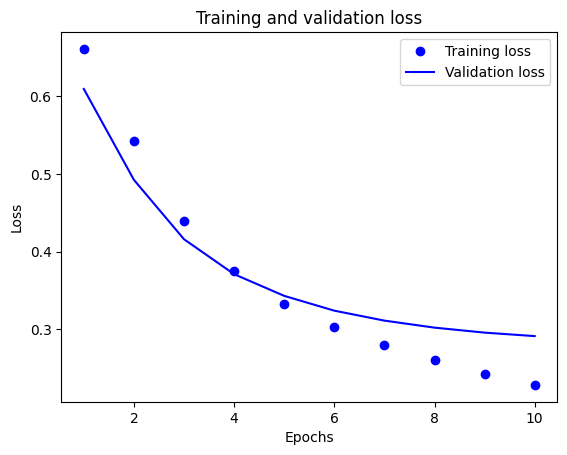

In [29]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

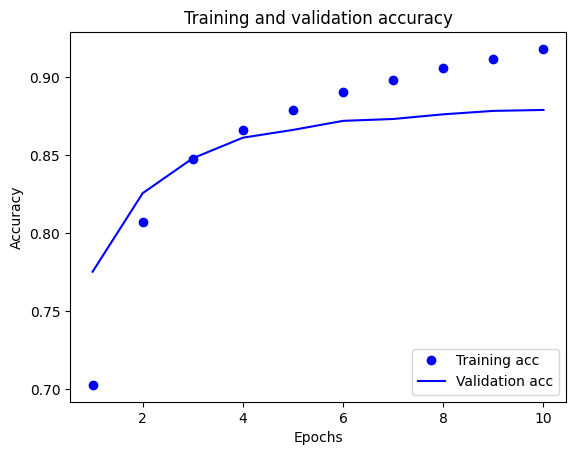

In [30]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the `tf.keras.callbacks.EarlyStopping` callback.

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [31]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

  1/782 [..............................] - ETA: 2:45 - loss: 0.3241 - accuracy: 0.8750

 15/782 [..............................] - ETA: 2s - loss: 0.3301 - accuracy: 0.8625  

 29/782 [>.............................] - ETA: 2s - loss: 0.3169 - accuracy: 0.8653

 44/782 [>.............................] - ETA: 2s - loss: 0.3179 - accuracy: 0.8629

 59/782 [=>............................] - ETA: 2s - loss: 0.3277 - accuracy: 0.8607

 73/782 [=>............................] - ETA: 2s - loss: 0.3263 - accuracy: 0.8622

 87/782 [==>...........................] - ETA: 2s - loss: 0.3170 - accuracy: 0.8678

100/782 [==>...........................] - ETA: 2s - loss: 0.3110 - accuracy: 0.8706

114/782 [===>..........................] - ETA: 2s - loss: 0.3114 - accuracy: 0.8714

129/782 [===>..........................] - ETA: 2s - loss: 0.3094 - accuracy: 0.8728

144/782 [====>.........................] - ETA: 2s - loss: 0.3080 - accuracy: 0.8737

158/782 [=====>........................] - ETA: 2s - loss: 0.3062 - accuracy: 0.8738

173/782 [=====>........................] - ETA: 2s - loss: 0.3101 - accuracy: 0.8730

188/782 [======>.......................] - ETA: 2s - loss: 0.3104 - accuracy: 0.8712

202/782 [======>.......................] - ETA: 2s - loss: 0.3099 - accuracy: 0.8719

216/782 [=======>......................] - ETA: 2s - loss: 0.3091 - accuracy: 0.8731

231/782 [=======>......................] - ETA: 1s - loss: 0.3090 - accuracy: 0.8734

246/782 [========>.....................] - ETA: 1s - loss: 0.3094 - accuracy: 0.8737

261/782 [=========>....................] - ETA: 1s - loss: 0.3092 - accuracy: 0.8734

276/782 [=========>....................] - ETA: 1s - loss: 0.3086 - accuracy: 0.8742

291/782 [==========>...................] - ETA: 1s - loss: 0.3089 - accuracy: 0.8749

307/782 [==========>...................] - ETA: 1s - loss: 0.3094 - accuracy: 0.8744

323/782 [===========>..................] - ETA: 1s - loss: 0.3096 - accuracy: 0.8747

338/782 [===========>..................] - ETA: 1s - loss: 0.3093 - accuracy: 0.8749

353/782 [============>.................] - ETA: 1s - loss: 0.3091 - accuracy: 0.8751

367/782 [=============>................] - ETA: 1s - loss: 0.3090 - accuracy: 0.8747

382/782 [=============>................] - ETA: 1s - loss: 0.3100 - accuracy: 0.8743

397/782 [==============>...............] - ETA: 1s - loss: 0.3118 - accuracy: 0.8733

412/782 [==============>...............] - ETA: 1s - loss: 0.3116 - accuracy: 0.8733

427/782 [===============>..............] - ETA: 1s - loss: 0.3136 - accuracy: 0.8721

441/782 [===============>..............] - ETA: 1s - loss: 0.3131 - accuracy: 0.8724

455/782 [================>.............] - ETA: 1s - loss: 0.3140 - accuracy: 0.8720

469/782 [================>.............] - ETA: 1s - loss: 0.3133 - accuracy: 0.8725

484/782 [=================>............] - ETA: 1s - loss: 0.3138 - accuracy: 0.8722

499/782 [==================>...........] - ETA: 0s - loss: 0.3138 - accuracy: 0.8722

514/782 [==================>...........] - ETA: 0s - loss: 0.3138 - accuracy: 0.8726

529/782 [===================>..........] - ETA: 0s - loss: 0.3143 - accuracy: 0.8726

544/782 [===================>..........] - ETA: 0s - loss: 0.3141 - accuracy: 0.8726

558/782 [====================>.........] - ETA: 0s - loss: 0.3131 - accuracy: 0.8728

573/782 [====================>.........] - ETA: 0s - loss: 0.3130 - accuracy: 0.8727

588/782 [=====================>........] - ETA: 0s - loss: 0.3120 - accuracy: 0.8728

603/782 [======================>.......] - ETA: 0s - loss: 0.3117 - accuracy: 0.8727

618/782 [======================>.......] - ETA: 0s - loss: 0.3106 - accuracy: 0.8730

633/782 [=======================>......] - ETA: 0s - loss: 0.3105 - accuracy: 0.8731

648/782 [=======================>......] - ETA: 0s - loss: 0.3096 - accuracy: 0.8735

663/782 [========================>.....] - ETA: 0s - loss: 0.3098 - accuracy: 0.8732

678/782 [=========================>....] - ETA: 0s - loss: 0.3094 - accuracy: 0.8738

693/782 [=========================>....] - ETA: 0s - loss: 0.3097 - accuracy: 0.8734

708/782 [==========================>...] - ETA: 0s - loss: 0.3095 - accuracy: 0.8733

723/782 [==========================>...] - ETA: 0s - loss: 0.3102 - accuracy: 0.8728

738/782 [===========================>..] - ETA: 0s - loss: 0.3101 - accuracy: 0.8725

753/782 [===========================>..] - ETA: 0s - loss: 0.3101 - accuracy: 0.8726

768/782 [============================>.] - ETA: 0s - loss: 0.3102 - accuracy: 0.8727

782/782 [==============================] - 3s 4ms/step - loss: 0.3102 - accuracy: 0.8727


0.8726800084114075


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [32]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 121ms/step


array([[0.610204  ],
       [0.43226102],
       [0.34722808]], dtype=float32)

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

## Exercise: multi-class classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multi-class classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

A [dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) has been prepared for you to use containing the body of several thousand programming questions (for example, "How can I sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python. 

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: To increase the difficulty of the classification problem, occurrences of the words Python, CSharp, JavaScript, or Java in the programming questions have been replaced with the word *blank* (as many questions contain the language they're about).

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) that has already been prepared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications.

1. Modify the last layer of your model to `Dense(4)`, as there are now four output classes.

1. When compiling the model, change the loss to `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`. This is the correct loss function to use for a multi-class classification problem, when the labels for each class are integers (in this case, they can be 0, *1*, *2*, or *3*). In addition, change the metrics to `metrics=['accuracy']`, since this is a multi-class classification problem (`tf.metrics.BinaryAccuracy` is only used for binary classifiers).

1. When plotting accuracy over time, change `binary_accuracy` and `val_binary_accuracy` to `accuracy` and `val_accuracy`, respectively.

1. Once these changes are complete, you will be able to train a multi-class classifier. 

## Learning more

This tutorial introduced text classification from scratch. To learn more about the text classification workflow in general, check out the [Text classification guide](https://developers.google.com/machine-learning/guides/text-classification/) from Google Developers.
